# Preparation

In [1]:
seed_value= 42

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
num_epochs  = 20
batch_size  = 32
num_classes = 10
shape       = (28, 28, 1)
opt_d       = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_g       = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
los         = keras.losses.BinaryCrossentropy()
latent_dim  = 28

# Dataset

In [5]:
def prepare_data(iteration, main_path, generated_path, replace):
    with np.load(main_path) as data:
        x_train, y_train = data['x_train'], data['y_train']
    
    if iteration == 0:
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        y_train = keras.utils.to_categorical(y_train, 10)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
    elif iteration == 6:
        with np.load(generated_path) as extra:
            extra_images, extra_labels = extra["images"], extra["labels"]
        
        if replace:
            x_train = extra_images
        else:
            x_train = np.concatenate((x_train, extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train, 10)
        
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        y_train = extra_labels
        
    else:
        with np.load(generated_path) as extra:
            extra_images, extra_labels = extra["images"], extra["labels"]
        
        if replace:
            added_len = len(extra_images) * -1
            x_train = np.concatenate((x_train[:added_len], extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train[:added_len], 10)
        else:
            x_train = np.concatenate((x_train, extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train, 10)
        
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        y_train = np.concatenate((y_train, extra_labels), axis=0)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
            
    print(f"Shape of training images: {x_train.shape}")
    print(f"Shape of training labels: {y_train.shape}")
    
    return train_dataset

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = shape[2] + num_classes   

# Model

In [6]:
def get_models():
    shared_input = keras.Input((shape[0], shape[1], discriminator_in_channels))
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(shared_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.GlobalMaxPooling2D()(x)

    real_fake_output = layers.Dense(1, activation="sigmoid", name="real_fake")(x)
    data_i_output = layers.Dense(1, activation="sigmoid", name="data_i_classification")(x)
    discriminator = keras.Model(shared_input, [real_fake_output, data_i_output], name="extended_discriminator")
    
    generator = keras.Sequential([keras.layers.InputLayer((generator_in_channels,)),
                                  layers.Dense(7 * 7 * generator_in_channels),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Reshape((7, 7, generator_in_channels)),
                                  layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")],
                                 name="generator")
    
    return discriminator, generator

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, reg_lambda):
        super().__init__()
        self.reg_lambda = reg_lambda
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.Generator.from_seed(seed_value)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data
    
        # Reshape and repeat one-hot labels to match the image dimensions
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[real_images.shape[1] * real_images.shape[2]], axis=-1)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, real_images.shape[1], real_images.shape[2], one_hot_labels.shape[-1]))
    
        batch_size = tf.shape(real_images)[0]
        
        # Generate random latent vectors
        random_latent_vectors = self.seed_generator.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        
        # Generate fake images
        generated_images = self.generator(random_vector_labels)
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
        
        # Labels for real vs. fake
        real_fake_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Labels for Data-I classification
        data_i_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
    
        # Train discriminator
        with tf.GradientTape() as tape:
            real_fake_predictions, data_i_predictions = self.discriminator(combined_images)
            d_real_fake_loss = self.loss_fn(real_fake_labels, real_fake_predictions)
            d_data_i_loss = self.loss_fn(data_i_labels, data_i_predictions)
            d_loss = d_real_fake_loss + d_data_i_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    
        # Train generator
        random_latent_vectors = self.seed_generator.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        misleading_real_fake_labels = tf.zeros((batch_size, 1))
        target_data_i_labels = tf.ones((batch_size, 1))  # Fool the Data-I classifier
        
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)
            fake_real_fake_predictions, fake_data_i_predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_real_fake_labels, fake_real_fake_predictions)
            reg_loss = tf.reduce_mean((target_data_i_labels - fake_data_i_predictions) ** 2)
            total_g_loss = g_loss + self.reg_lambda * reg_loss
        grads = tape.gradient(total_g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # Update loss trackers
        self.gen_loss_tracker.update_state(total_g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "loss": self.gen_loss_tracker.result() + self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Train

In [8]:
def interpolate_class(first_number, second_number, num_interpolation, interpolation_noise, trained_gen):
    first_label = tf.keras.utils.to_categorical([first_number], num_classes)
    second_label = tf.keras.utils.to_categorical([second_number], num_classes)
    
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    percent_second_label = tf.linspace(0.0, 1.0, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    
    interpolation_labels = (first_label * (1 - percent_second_label) + second_label * percent_second_label)

    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], axis=1)

    fake_images = trained_gen(noise_and_labels)

    return fake_images


def plot_generated_samples(first_class, second_class, num_interpolation, interpolation_noise, trained_gen):
    generated_images = interpolate_class(first_class, second_class, num_interpolation, interpolation_noise, trained_gen)
    generated_images = generated_images.numpy() * 255

    plt.figure(figsize=(15, 3))
    for i in range(num_interpolation):
        plt.subplot(1, num_interpolation, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    

def generate_and_save_images(generator, num_images, save_path):
    all_labels = []
    all_generated_images = []
    
    num_batches = int(np.ceil(num_images / batch_size))
    
    for batch_idx in range(num_batches):
        batch_size_actual = min(batch_size, num_images - batch_idx * batch_size)

        random_latent_vectors = tf.random.normal(shape=(batch_size_actual, latent_dim))
        
        random_labels = np.random.randint(0, num_classes, size=batch_size_actual)
        one_hot_labels = tf.keras.utils.to_categorical(random_labels, num_classes=num_classes)
        
        noise_and_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        
        generated_images = generator(noise_and_labels)
        generated_images = generated_images.numpy() * 255
        
        all_labels.append(one_hot_labels)
        all_generated_images.append(generated_images)

    all_generated_images = np.concatenate(all_generated_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    np.savez_compressed(save_path, images=all_generated_images[:, :, :, 0], labels=all_labels)
    print(f"Generated {num_images} images and labels, and saved to {save_path}")

Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 25s 12ms/step - loss: 2.4250 - g_loss: 1.7553 - d_loss: 0.6698
Epoch 2/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.2807 - g_loss: 1.6625 - d_loss: 0.6182
Epoch 3/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.3327 - g_loss: 1.7494 - d_loss: 0.5833
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.5364 - g_loss: 1.9672 - d_loss: 0.5692
Epoch 5/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.5153 - g_loss: 1.9491 - d_loss: 0.5663
Epoch 6/20
1875/1875 [==============================] - 23s 12ms/step - loss: 2.4292 - g_loss: 1.8282 - d_loss: 0.6010
Epoch 7/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.5082 - g_loss: 1.9321 - d_loss: 0.5761
Epoch 8/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.6152

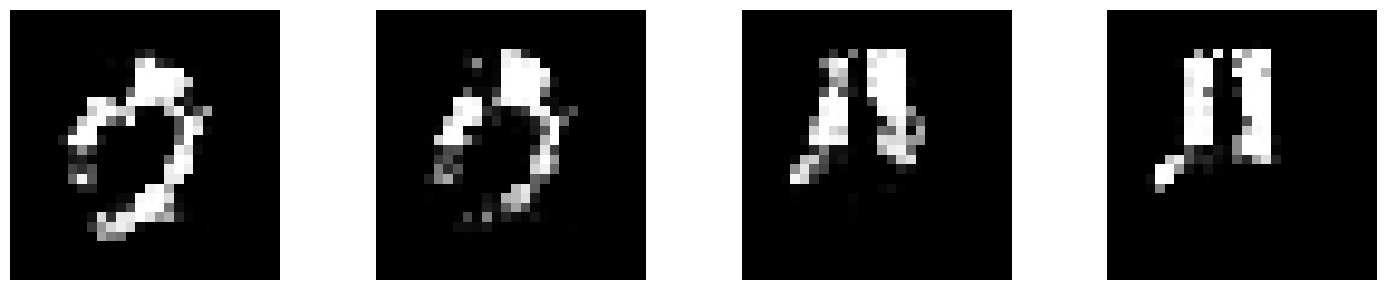

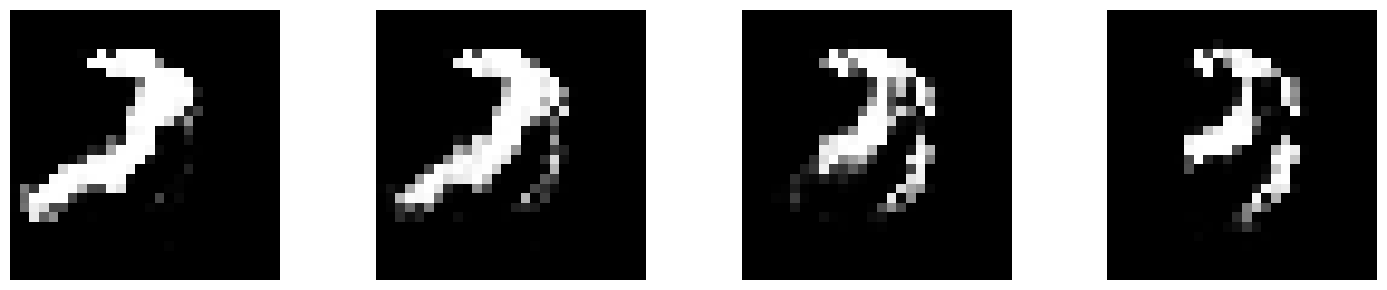

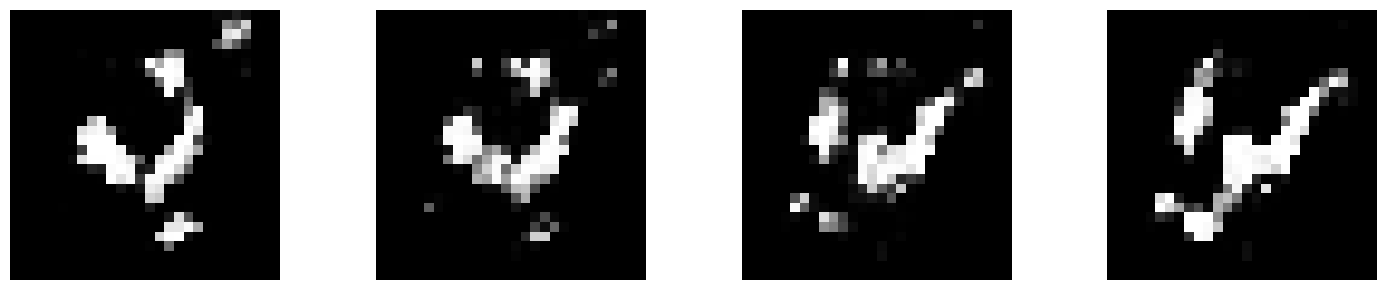

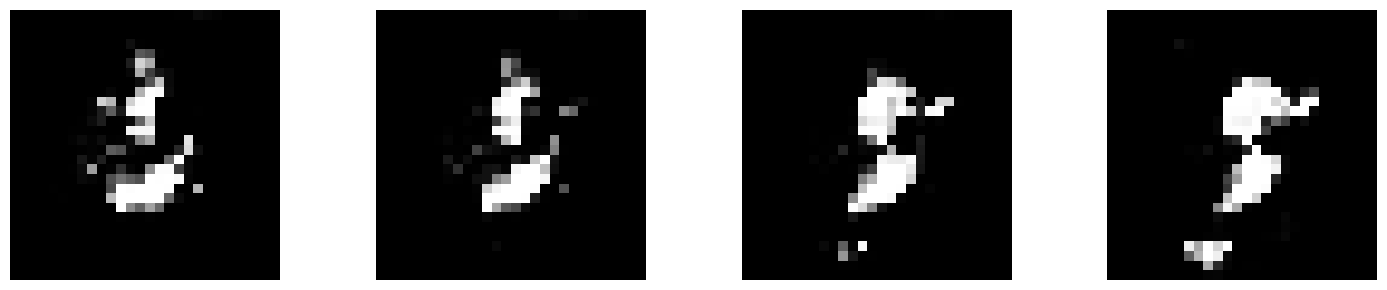

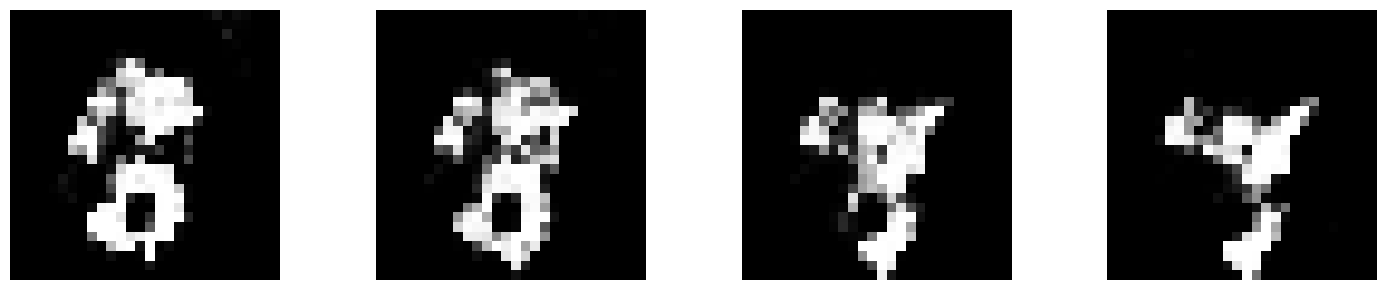

Generated 10000 images and labels, and saved to ../Dataset/Reg_Extra_1.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 23s 12ms/step - loss: 2.4783 - g_loss: 1.8496 - d_loss: 0.6287
Epoch 2/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.6741 - g_loss: 1.9614 - d_loss: 0.7127
Epoch 3/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.8589 - g_loss: 2.1319 - d_loss: 0.7271
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.8796 - g_loss: 2.0857 - d_loss: 0.7939
Epoch 5/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.8401 - g_loss: 2.0672 - d_loss: 0.7730
Epoch 6/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.7853 - g_loss: 2.0163 - d_loss: 0.7691
Epoch 7/20
1875/1875 [==============================] - 22s 12ms/step - loss: 2.8339 - g_loss: 2.0527 - d_loss: 0.7812
Epoch 8/2

In [ ]:
def train_iteration(iteration):
    # Dataset
    train_dataset = prepare_data(iteration=iteration, 
                                 main_path="../Dataset/mnist.npz", 
                                 generated_path=f"../Dataset/Reg_Extra_{iteration}.npz", 
                                 replace=True)
    
    # Model
    reg_lambda = 5.0
    discriminator, generator = get_models()
    cond_gan = ConditionalGAN(discriminator=discriminator, 
                              generator=generator, 
                              latent_dim=latent_dim, 
                              reg_lambda=reg_lambda)
    cond_gan.compile(d_optimizer=opt_d, g_optimizer=opt_g, loss_fn=los)
    reg_lambda *= 1.5
    
    # Train
    cond_gan.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, verbose=1)
    
    # Evaluation
    trained_gen = cond_gan.generator
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    interpolation_noise = tf.repeat(interpolation_noise, repeats=4, axis=0)
    plot_generated_samples(0, 1, 4, interpolation_noise, trained_gen)
    plot_generated_samples(2, 3, 4, interpolation_noise, trained_gen)
    plot_generated_samples(4, 5, 4, interpolation_noise, trained_gen)
    plot_generated_samples(6, 7, 4, interpolation_noise, trained_gen)
    plot_generated_samples(8, 9, 4, interpolation_noise, trained_gen)
    
    # Generation
    generate_and_save_images(trained_gen, 10000*(iteration+1), f"../Dataset/Reg_Extra_{iteration+1}.npz")
    
for i in range(7):
    train_iteration(i)